In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('PROJECT_ROOT:', PROJECT_ROOT)

PROJECT_ROOT: /Users/foivosampatzis/Documents/Projects/systematic_trading_framework


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from src.data.loaders import load_ohlcv
from src.data.validation import validate_ohlcv
from src.features import add_close_returns, add_volatility_features, add_lagged_features
from src.features.technical.trend import add_trend_features, add_trend_regime_features
from src.features.technical.momentum import add_momentum_features
from src.features.technical.oscillators import add_oscillator_features
from src.features.technical.indicators import add_indicator_features
from src.models.lightgbm_baseline import train_test_split_time
from src.risk.position_sizing import scale_signal_by_vol
from src.backtesting.engine import run_backtest
from src.backtesting.strategies import buy_and_hold_signal


/Users/foivosampatzis/Documents/Projects/systematic_trading_framework/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:

symbol = "6E=F"  

df = load_ohlcv(symbol, start='2015-01-01', interval='1d', source='yahoo')
validate_ohlcv(df)

df = add_close_returns(df, log=False, col_name='close_ret')
df = add_volatility_features(df, returns_col='close_ret', rolling_windows=(20, 60), ewma_spans=(20,))
df = add_trend_features(df, price_col='close', sma_windows=(20, 50), ema_spans=(20,))
df = add_trend_regime_features(df, price_col='close', base_sma_for_sign=50, short_sma=20, long_sma=50)
df = add_momentum_features(df, price_col='close', returns_col='close_ret', vol_col='vol_rolling_20', windows=(5, 20))
df = add_oscillator_features(df, price_col='close', high_col='high', low_col='low', rsi_windows=(14,), stoch_windows=(14,), stoch_smooth=3)
df = add_indicator_features(df, price_col='close', high_col='high', low_col='low', volume_col='volume', include_mfi=True)

df = add_lagged_features(df, cols=['close_ret'], lags=(1, 2, 5))

df = df.dropna()
df.head()


,open,high,low,close,volume,close_ret,vol_rolling_20,vol_rolling_60,vol_ewma_20,close_sma_20,...,atr_over_price_14,plus_di_14,minus_di_14,adx_14,volume_z_20,volume_over_atr_14,mfi_14,lag_close_ret_1,lag_close_ret_2,lag_close_ret_5
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-31,1.0838,1.0857,1.0724,1.0754,229296,-0.007384,0.160148,0.123743,0.142034,1.079050,...,0.014793,14.987332,21.467359,29.921755,-0.787523,1.441385e+07,62.426992,-0.007512,0.003124,-0.002191
2015-04-01,1.0752,1.0811,1.0729,1.0775,237236,0.001953,0.158153,0.123738,0.135922,1.077550,...,0.014253,14.415739,20.648628,29.054170,-0.695661,1.544761e+07,55.435573,-0.007384,-0.007512,0.003843
2015-04-02,1.0775,1.0916,1.0760,1.0905,225076,0.012065,0.164623,0.126900,0.143318,1.076935,...,0.014099,18.249059,19.152124,27.151339,-0.776219,1.463930e+07,59.285449,0.001953,-0.007384,-0.008203
2015-04-06,1.1007,1.1047,1.0920,1.0987,108231,0.007520,0.157158,0.127946,0.140552,1.077575,...,0.013917,23.157997,17.881712,26.130281,-1.685763,7.078147e+06,57.922111,0.012065,0.001953,0.003124
2015-04-07,1.0942,1.0965,1.0813,1.0839,223168,-0.013471,0.164957,0.130084,0.150626,1.077470,...,0.014246,21.294053,21.391991,24.280221,-0.649855,1.445246e+07,52.154154,0.007520,0.012065,-0.007512


In [4]:

fwd = 10
df['target_fwd'] = df['close'].pct_change(periods=fwd).shift(-fwd)
df = df.dropna(subset=['target_fwd'])

q_low, q_high = df['target_fwd'].quantile([0.2, 0.8])
mask = (df['target_fwd'] <= q_low) | (df['target_fwd'] >= q_high)
df = df.loc[mask]
df['label'] = (df['target_fwd'] >= q_high).astype(int) 

feature_cols = [
    'close_ret', 'vol_rolling_20',
    'vol_rolling_60', 'vol_ewma_20', 'close_sma_20', 'close_over_sma_20',
    'close_sma_50', 'close_over_sma_50', 'close_ema_20',
    'close_over_ema_20', 'close_trend_regime_sma_50',
    'close_trend_state_sma_20_50', 'close_mom_5', 'close_ret_mom_5',
    'close_ret_norm_mom_5', 'close_mom_20', 'close_ret_mom_20',
    'close_ret_norm_mom_20', 'close_rsi_14', 'close_stoch_k_14',
    'close_stoch_d_14', 'bb_ma_20', 'bb_upper_20_2.0', 'bb_lower_20_2.0',
    'bb_width_20_2.0', 'bb_percent_b_20_2.0', 'macd_12_26', 'macd_signal_9',
    'macd_hist_12_26_9', 'ppo_12_26', 'ppo_signal_9', 'ppo_hist_12_26_9',
    'roc_10', 'roc_20', 'atr_14', 'atr_over_price_14', 'plus_di_14',
    'minus_di_14', 'adx_14', 'volume_z_20', 'volume_over_atr_14', 'mfi_14',
    'lag_close_ret_1', 'lag_close_ret_2', 'lag_close_ret_5',
]
feature_cols = [c for c in feature_cols if c in df.columns]
print('Using features:', feature_cols)

train_df, test_df = train_test_split_time(df, train_frac=0.75)
train_df.shape, test_df.shape


Using features: ['close_ret', 'vol_rolling_20', 'vol_rolling_60', 'vol_ewma_20', 'close_sma_20', 'close_over_sma_20', 'close_sma_50', 'close_over_sma_50', 'close_ema_20', 'close_over_ema_20', 'close_trend_regime_sma_50', 'close_trend_state_sma_20_50', 'close_mom_5', 'close_ret_mom_5', 'close_ret_norm_mom_5', 'close_mom_20', 'close_ret_mom_20', 'close_ret_norm_mom_20', 'close_rsi_14', 'close_stoch_k_14', 'close_stoch_d_14', 'bb_ma_20', 'bb_upper_20_2.0', 'bb_lower_20_2.0', 'bb_width_20_2.0', 'bb_percent_b_20_2.0', 'macd_12_26', 'macd_signal_9', 'macd_hist_12_26_9', 'ppo_12_26', 'ppo_signal_9', 'ppo_hist_12_26_9', 'roc_10', 'roc_20', 'atr_14', 'atr_over_price_14', 'plus_di_14', 'minus_di_14', 'adx_14', 'volume_z_20', 'volume_over_atr_14', 'mfi_14', 'lag_close_ret_1', 'lag_close_ret_2', 'lag_close_ret_5']


((816, 52), (272, 52))

In [5]:
clf = LGBMClassifier(
    objective='binary',
    n_estimators=600,
    learning_rate=0.02,
    num_leaves=63,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=10,
    min_split_gain=0.0,
    random_state=7,
    n_jobs=-1,
)

clf.fit(train_df[feature_cols], train_df['label'])

test_df = test_df.copy() 
test_df['pred_prob'] = clf.predict_proba(test_df[feature_cols])[:, 1]
test_df[['pred_prob', 'label']].head()

[LightGBM] [Info] Number of positive: 407, number of negative: 409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10971
[LightGBM] [Info] Number of data points in the train set: 816, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498775 -> initscore=-0.004902
[LightGBM] [Info] Start training from score -0.004902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,pred_prob,label
Date,,
2023-03-17,0.950529,1
2023-03-20,0.892673,1
2023-03-21,0.413534,1
2023-03-28,0.065789,1
2023-03-29,0.078952,1


In [6]:
upper = 0.58  
lower = 0.42  

test_df = test_df.copy()  
test_df['signal_prob'] = (test_df['pred_prob'] > upper).astype(float) - (test_df['pred_prob'] < lower).astype(float)

test_df['signal_prob_size'] = 2*(test_df['pred_prob'] - 0.5)
test_df['signal_prob_size'] = test_df['signal_prob_size'].clip(-1, 1)
test_df['signal_prob_size_vol'] = scale_signal_by_vol(
    signal=test_df['signal_prob_size'],
    vol=test_df['vol_rolling_20'],
    target_vol=0.10,
    max_leverage=2.0,
)

test_df['signal_prob_regime'] = test_df['signal_prob']
test_df.loc[test_df['close_trend_state_sma_20_50'] != 1, 'signal_prob_regime'] = 0.0

test_df['signal_bh'] = buy_and_hold_signal(test_df)

res_bh = run_backtest(test_df, signal_col='signal_bh', returns_col='close_ret', cost_per_unit_turnover=0.0002)
res_prob = run_backtest(test_df, signal_col='signal_prob', returns_col='close_ret', cost_per_unit_turnover=0.0002)
res_prob_reg = run_backtest(test_df, signal_col='signal_prob_regime', returns_col='close_ret', cost_per_unit_turnover=0.0002)
res_prob_vol = run_backtest(test_df, signal_col='signal_prob_size_vol', returns_col='close_ret', cost_per_unit_turnover=0.0002)

res_bh.summary, res_prob.summary, res_prob_reg.summary, res_prob_vol.summary


({'cumulative_return': 0.12096099053774645,
  'annualized_return': 0.11158874070057712,
  'annualized_vol': 0.07497203224947398,
  'sharpe': 1.4884049071693672,
  'max_drawdown': -0.06354881874017593},
 {'cumulative_return': 0.10347718635529857,
  'annualized_return': 0.09551667960511456,
  'annualized_vol': 0.06757066248823909,
  'sharpe': 1.4135821092732304,
  'max_drawdown': -0.042360597807792666},
 {'cumulative_return': 0.09112751010048492,
  'annualized_return': 0.08415291521574852,
  'annualized_vol': 0.05455391789208865,
  'sharpe': 1.5425640992863006,
  'max_drawdown': -0.041944676074834875},
 {'cumulative_return': 0.06662576368717543,
  'annualized_return': 0.061579097281206696,
  'annualized_vol': 0.0723675127462023,
  'sharpe': 0.8509218424732753,
  'max_drawdown': -0.06826926363623553})

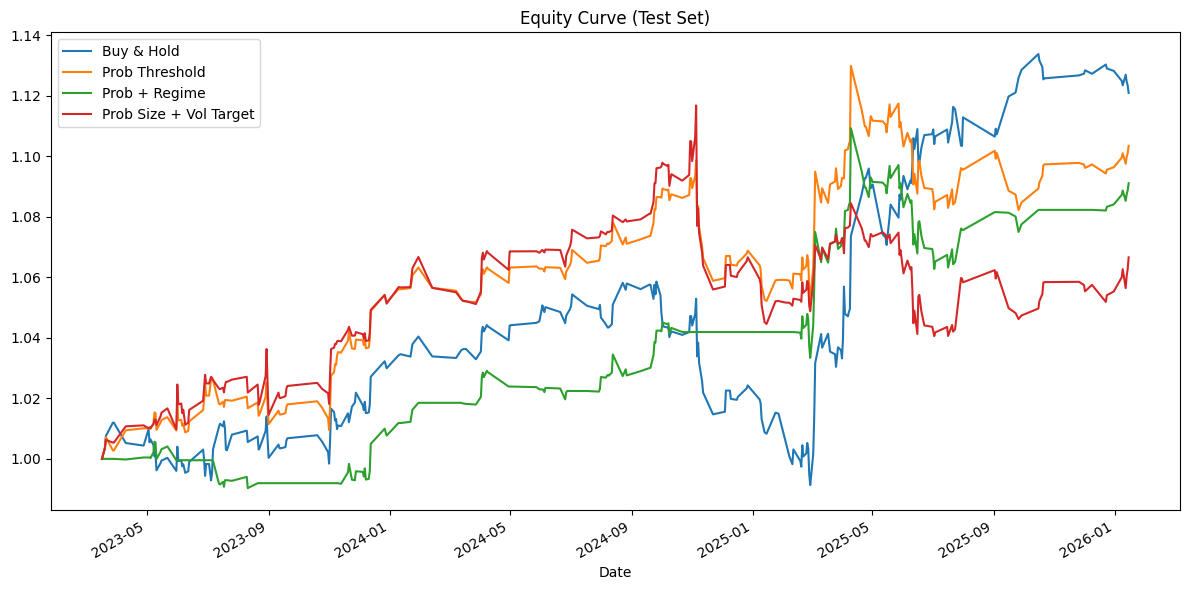

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
res_bh.equity_curve.plot(ax=ax, label='Buy & Hold')
res_prob.equity_curve.plot(ax=ax, label='Prob Threshold')
res_prob_reg.equity_curve.plot(ax=ax, label='Prob + Regime')
res_prob_vol.equity_curve.plot(ax=ax, label='Prob Size + Vol Target')
ax.legend(); ax.set_title('Equity Curve (Test Set)');
plt.tight_layout()
